<a href="https://colab.research.google.com/github/dpapp86/ISMRM_2022/blob/main/Realtime_dynanmic_xyz_shimming_in_the_cervical_spinal_cord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---

This is an interactive notebook for the following ISMRM digital poster:


> **"Realtime Dynamic XYZ-shimming in the cervical spinal cord"**

> *Daniel Papp, Alexandre D'Astous, Jullien Cohen-Adad, Eva Alonso-Ortiz*

Program number 2353

---
---

In brief, within this poster, we demonstrate that for best outcomes, respiration-induced B0 distortions need to be compensated for using realtime (varying with respiration), dynamic (slicewise) shimming gradients played out both through-plane (z) and in-plane (x-y) as well. 

This notebook demonstrates our processing pipeline, including necessary sanity checks, and provides examples of data visualisation. 

An effort has been made to make the notebook self-explanatory and well commented. However, any comments/issues should be directed at Daniel Papp (daniel.papp@polymtl.ca)

This notebook will do the following:


1.   Install all the necessary toolboxes, libraries, and finally download the data from OSF
2.   Using the Spinal Cord Toolbox, segment the spinal cord from the T1w scan and apply this segmentation to all MGRE scans, following a coregistration step
3. Extract the relevant data (signal intensity within the spinal cord for each slice, TE, and shimming condition)
4. Generate plots of the standard deviation and mean of this signal across slices for each TE and shim condition 
5. Generate violin plots for better visualisation

Enjoy!

---
---


# **Introduction**

In spinal cord (SC) MRI, proximity to the lungs imposes time-varying changes to the magnetic field for each imaging slice that cannot  be compensated using only static gradients [1,2]. A recently introduced approach, called realtime dynamic z-shimming [3] employs dynamic (slice-wise) z-shimming with realtime adjustments of z-shimming gradients to correct for respiration-induced field changes. However, dynamic z-himming and realtime dynamic z-shimming methods presuppose that in-plane field gradients lead to negligible phase accrual. Here, we propose a dynamic shimming solution that compensates for both through-plane and in-plane field gradients ("dynamic xyz-shimming) and extend this technique to compensate for respiration-induced field gradients ("realtime dynamic xyz-shimming"). 

# **Theory**

During respiration, magnetic field gradients within the imaging (x-y) plane, $G_z(x,y,t), G_y(x,y,t), G_x(x,y,t)$ can be separated into static and realtime components: 

$G_z(x,y,t) = G_{z,static}(x,y)+RIGO_z(x,y)\cdot P(t),    \qquad$ [Eq. 1]

$G_y(x,y,t) = G_{y,static}(x,y)+RIGO_y(x,y) \cdot P(t), \qquad$  [Eq. 2]

$G_x(x,y,t) = G_{x,static}(x,y)+RIGO_x(x,y) \cdot P(t), \qquad$  [Eq. 3]


$RIGO_z(x,y), RIGO_y(x,y), RIGO_x(x,y)$ are the amplitudes of the respiration-induced gradient offset and $P(t)$ represents a time-varying sinusoidal pressure of respiration.

If $G_z(x,y,t), G_y(x,y,t), G_x(x,y,t)$ do not vary considerably in-plane [3], they can be minimized by including correction gradients within an imaging sequence along the slice-select (“z”) [3] and in-plane (“x” and “y”) directions ($G_{z,corr},G_{y,corr},G_{x,corr}$) (Figure 1).

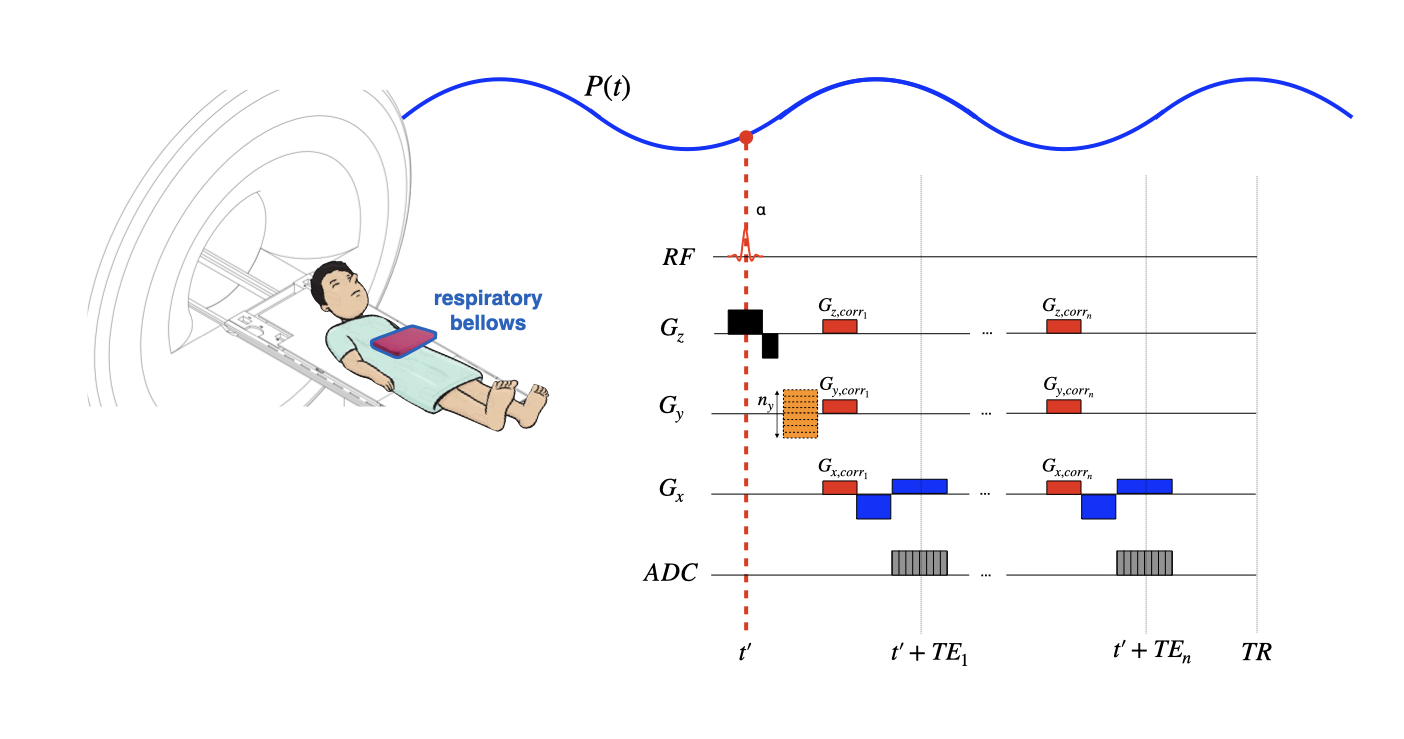


Figure 1: Schematic of the realtime dynamic xyz-shimming approach. For each TR and echo time, the correction gradients ($G_{corr}$) are played out prior to sampling. The correction gradients are the sum of the static component $G_{static}$, and the respiration-induced gradient offset (RIGO) component, modulated by pressure P(t), and adjusted for echo time.

# **Acquisition**

## Training Session

Scans were acquired on one volunteer (26, M) using a 3 T Siemens Prisma-fit scanner and a 64 channel head-neck receiver coil. Respiratory bellows were used to monitor and log breathing throughout the session. A 3D T1-weighted scan (T1w, TR/TE = 15/3.15 ms, FOV = 256 x 256 x 66 mm$^3$, resolution = 0.9 x 0.9 x 3 mm$^3$, FA = 15°) was acquired. Then a series of 30 sequential dual-echo ΔB0 maps were acquired in the sagittal orientation covering the cervical SC (TR/TE1/TE2 = 35/2.14/4.6 ms, 2.2 x 2.2 mm$^2$ in-plane resolution, 5 slices of 2.2 mm$^2$ thickness, FA=20°). The scanner’s first and second order shim adjustment volume was optimized in the SC. The adjustment volume and first/second-order shim currents for this scan were used throughout the session. An axial 2D multi-echo gradient-echo (MGRE) scan (**noshim**) was acquired (6 echoes, TR/TE1/echo spacing =189/2.5/2.2 ms, BW = 600 Hz/px, 12 slices of 3 mm thickness, matrix = 128 x 56, image resolution = 2.2 x 2.2 mm$^2$, FA = 20°) oriented perpendicularly to the SC at C6/C7. All of the data were transferred offline via ethernet for shim calculation (see Step 1, Figure 2).

Using the log from the bellows, each ΔB0 map was associated with a pressure reading. The [shimming toolbox (ST)](https://shimming-toolbox.org/en/latest/) [4] was used to compute the gradient along each axis for each ΔB0 map. A voxelwise linear regression between pressure and gradient was performed to derive images of static and RIGO components (see Step 2, Figure 2). 

The [Spinal Cord Toolbox (SCT)](https://spinalcordtoolbox.com/) [5] was used to generate a SC mask using the noshim scan and the static and RIGO component images were resampled and registered to the noshim scan. The mean of the static and RIGO components were calculated within the SC mask ($<G_{z,static}>,<G_{y,static}>,<G_{x,static}>$ and $<RIGO_z>,<RIGO_y>,<RIGO_x>$) for each slice and transferred to the scanner (see Step 3, Figure 2).

## Imaging Session

Next, 2D MGRE images were acquired using the same acquisition parameters and orientation as the noshim scan, under 4 dynamic shimming scenarios: static z-shim (**ST-zshim**), where the compensation gradients were only played out along the z direction and not adjusted in real time, (2) static xyz-shimming (**ST-xyzshim**), where correction gradients were played out in-plane as well as through-plane, (3) real-time z-shim (**RT-zshim**), where the correction gradients along the z-direction were adjusted in real-time, and (4) real-time xyz-shimming (**RT-xyzshim**), where correction gradients were played out along all three axes and adjusted in real time. 

The $<G_{z,static}>,<G_{y,static}>,<G_{x,static}>$ and $<RIGO_z>,<RIGO_y>,<RIGO_x>$ values for each slice were read by the sequence at the start of the start of the acquisition and the pressure on the bellows was continuously sampled by the scanner at a rate of 50 Hz (see Step 4, Figure 2). For static shimming, only $<G_{z,static}>,<G_{y,static}>,<G_{x,static}>$ were taken into account. For realtime shimming, $<RIGO_z>,<RIGO_y>,<RIGO_x>$ components were used as well, modulated by bellows pressure: 

$<G_z>=<G_{z,static}>+<RIGO_z>\cdot P(t'),    \qquad$						 [Eq. 7]

$<G_y>=<G_{y,static}>+<RIGO_y>\cdot P(t'),    \qquad$						 [Eq. 8]

$<G_x>=<G_{x,static}>+<RIGO_x>\cdot P(t'),    \qquad$ 						 [Eq. 9]

Where $P(t')$ is the pressure measured by the respiratory bellows at a time t’, equal to the excitation time of the slice in question. Finally, using $<G_z>,<G_y>,<G_x>$ the appropriate correction gradients are computed and played out by the sequence. 

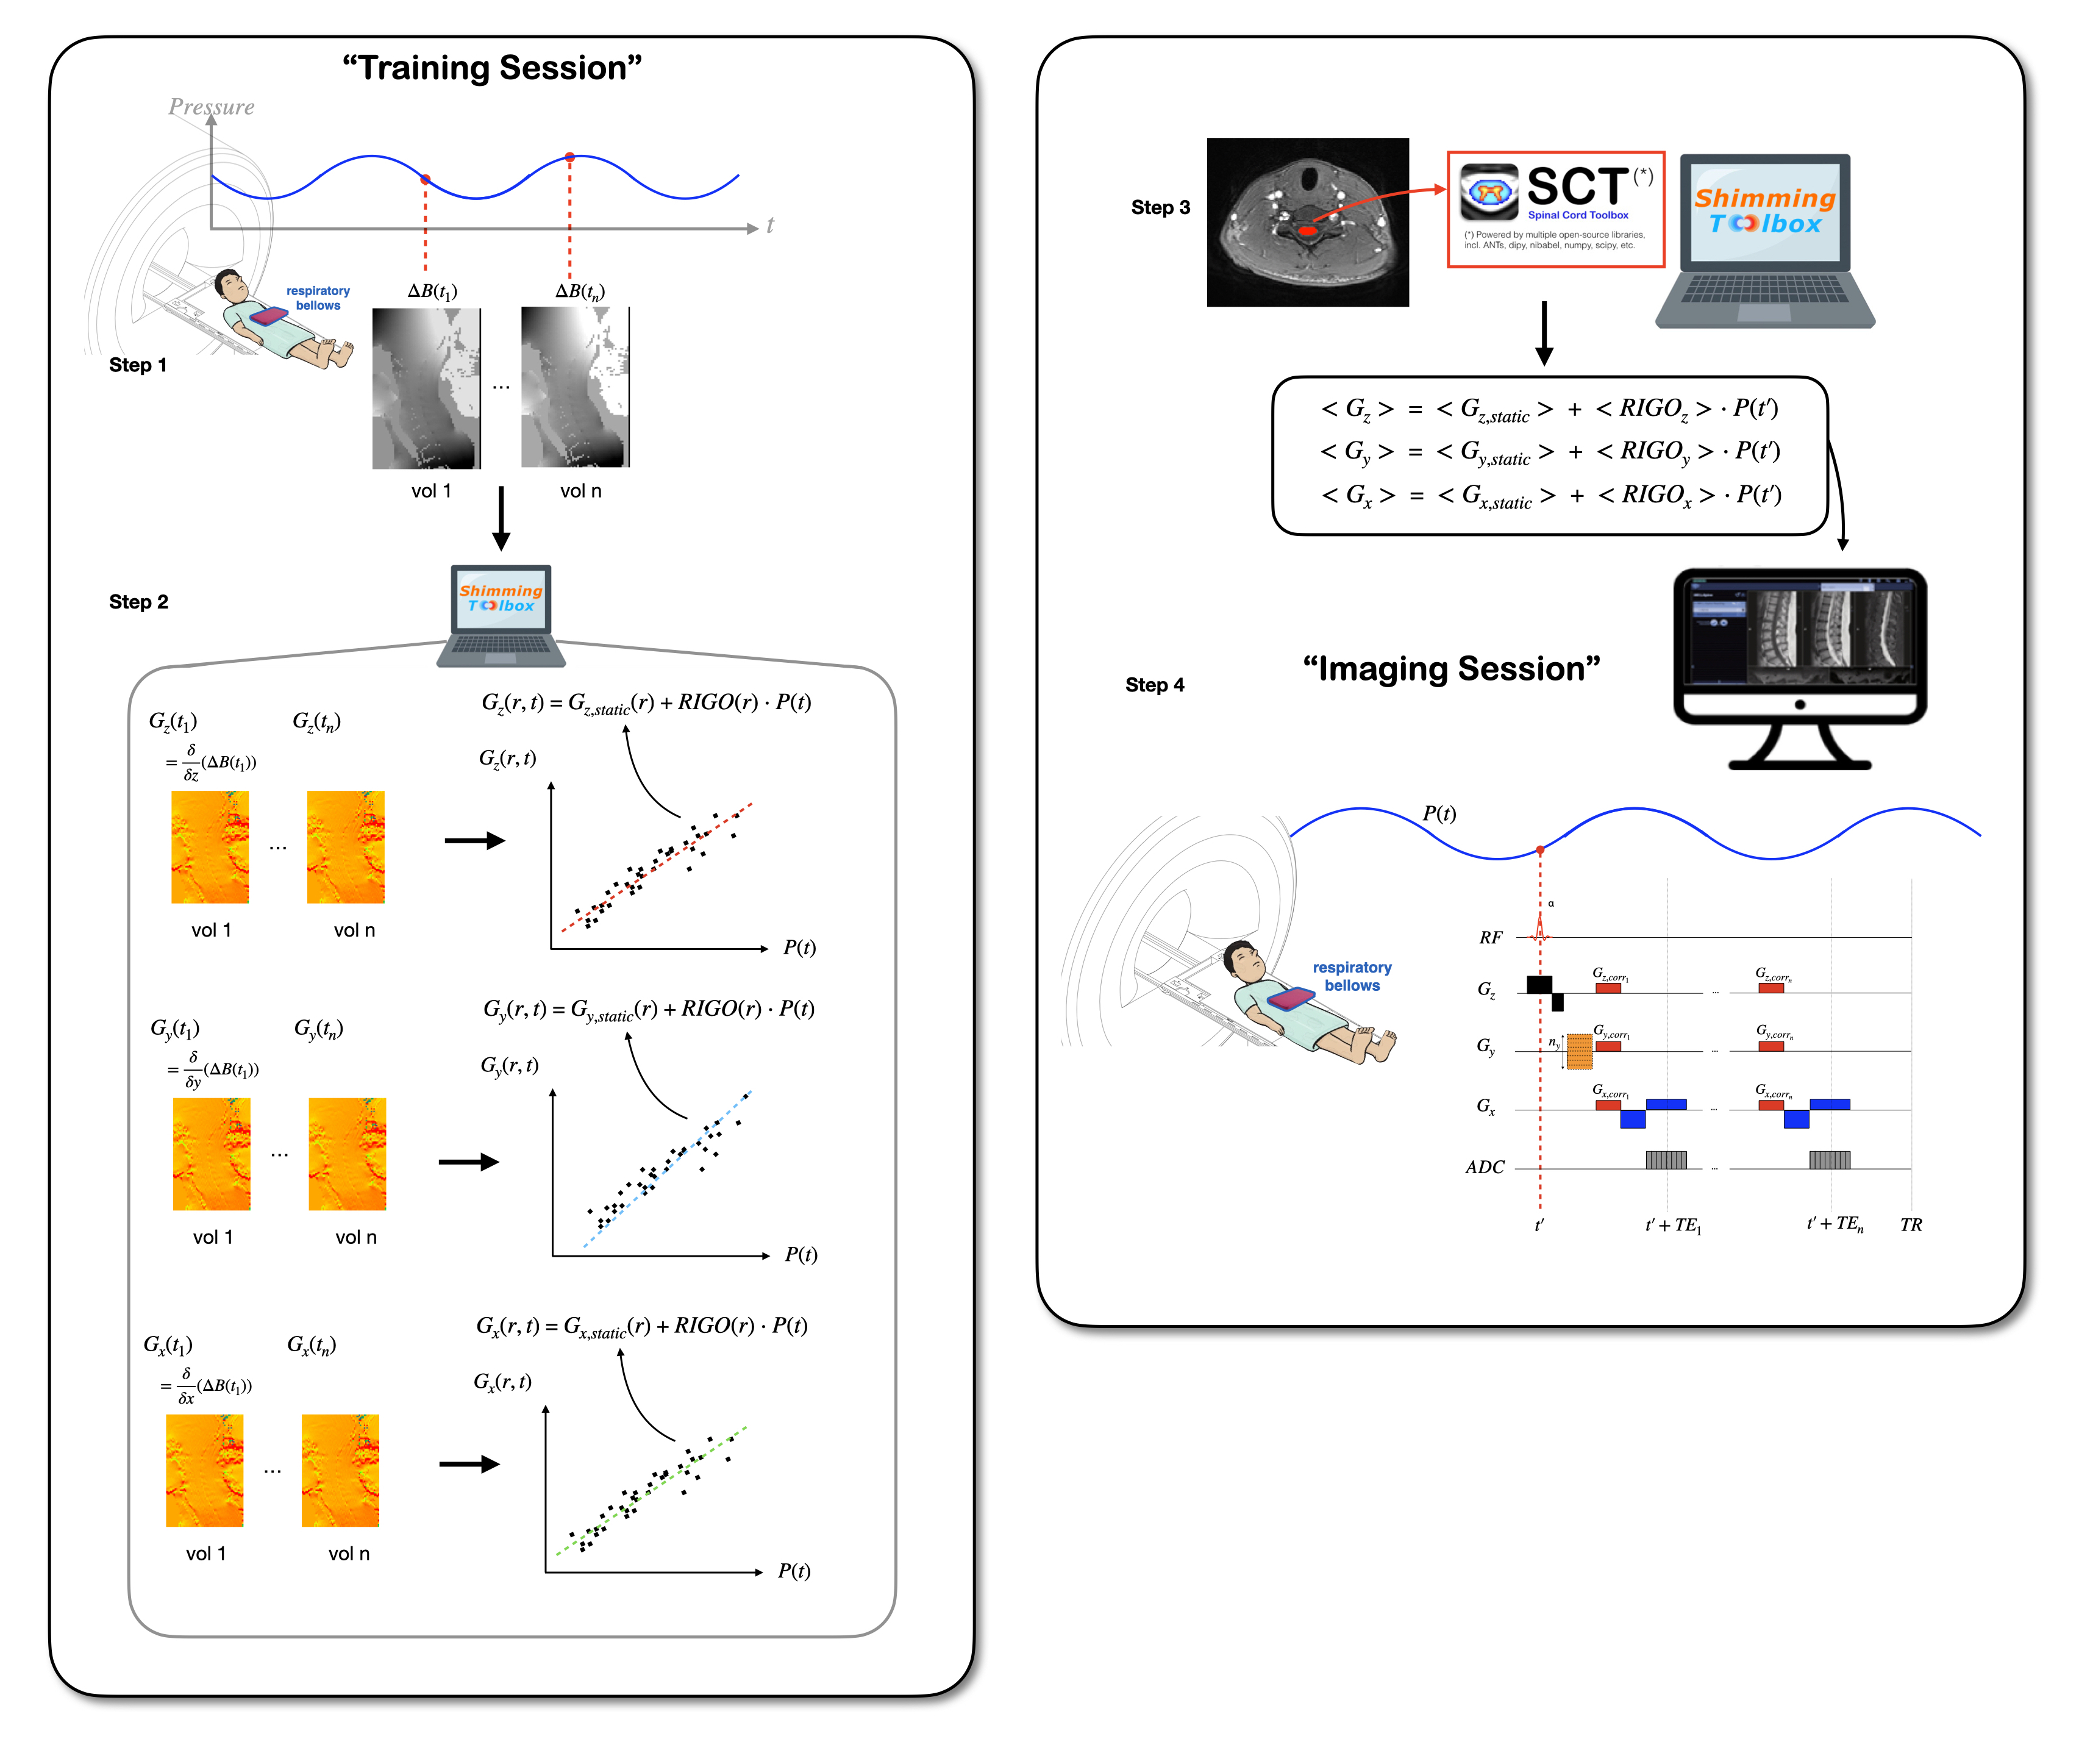

Figure 2: Dynamic realtime shimming workflow

# **Analysis**


## Setup: importing toolboxes, libraries, and data

In [ ]:
# IMPORTING LIBRARIES AND INSTALLING NECESSARY TOOLS
# First, lets make sure we are in the right directory for all the path definitions to work (/content/)
import os
currpath=os.getcwd()
if currpath!='/content':
  print("********** Not in the correct directory for the rest of the code, changing directories **********")
  os.chdir('/content/')
else:
  print("********** In the correct directory, proceeding **********")

#Now we can import all the necessary libraries



# Path handling, file operations, etc
import os
from os.path import join
import glob
import zipfile
import shutil
import logging
import subprocess
import fnmatch
import pathlib
import time

# Pydicom needs to be installed if we want to import it
!pip install pydicom > /dev/null
import pydicom
print("********** Pydicom installed **********")
# Data handling, visualisation, etc

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nibabel as nib
import pandas as pd
%matplotlib inline
import seaborn as sns

# DCM2NIIX is necessary for DCM-to-NIFTI conversion after the DCM data has been checked for table position issues
os.chdir('/content/')
!git clone https://github.com/rordenlab/dcm2niix.git > /dev/null
os.chdir('/content/dcm2niix')
if os.path.isdir('/content/dcm2niix/build/'): #Here, we remove old, trailing installs (from an interrupter runtime, let's say) so we can start with a clean slate
  shutil.rmtree('/content/dcm2niix/build/')
os.mkdir('/content/dcm2niix/build/')
os.chdir('/content/dcm2niix/build/')
!cmake ..
!make install > /dev/null #Suppressing outputs to keep the output readibly small. Errors are NOT supressed

os.environ['PATH'] += ':/content/dcm2niix/build/bin/'
print("********** DCM2NIIX installed **********")

######### Spinal cord toolbox installation
os.chdir('/content/')
!git clone --depth 1 --branch 5.3.0 https://github.com/spinalcordtoolbox/spinalcordtoolbox > /dev/null
% cd spinalcordtoolbox/
!yes | ./install_sct > /dev/null
print("********** Spinal Cord Toolbox installed **********")

######### Spinal cord toolbox environment setup
os.environ['PATH'] += ':/content/spinalcordtoolbox/bin'
os.environ['SCT_DIR'] = '/content/spinalcordtoolbox'
print("********** Spinal Cord Toolbox path set **********")

# We host our data on OSF
# To handle it, we need the OSF client, installed here
os.chdir('/content/')
! git clone https://github.com/osfclient/osfclient > /dev/null

% cd osfclient/ 

! pip install osfclient > /dev/null
print('********** OSF client installed **********')
## Here, we download the dataset shown in the ISMRM abstract
os.chdir('/content/osfclient/')
! osf -p fy3h4 fetch /ISMRM/Subjects.zip /content/osfclient/Subjects.zip
print("********** ISMRM data suscesfully downloaded **********")
zipped_subject='/content/osfclient/Subjects.zip'
with zipfile.ZipFile(zipped_subject,"r") as zip_ref:
  zip_ref.extractall('/content/')
# clearing up annoying _MACOSX directory
shutil.rmtree('/content/__MACOSX')
print("********** Unzipping done **********")    

# Helper function wrapping subprocess
def run_subprocess(cmd):
    """Wrapper for ``subprocess.run()`` that enables to input ``cmd`` as a full string (easier for debugging).
    Args:
        cmd (string): full command to be run on the command line
    """
    # logging.debug(f'{cmd}')
    try:
        subprocess.run(
            cmd.split(' '),
            text=True,
            check=True
            # env=env
        )
    except subprocess.CalledProcessError as err:
        msg = "Return code: ", err.returncode, "\nOutput: ", err.stderr
        raise Exception(msg)



print('********** All necessary libraries imported, all necessary toolboxes installed! **********')
print('********** We can proceeed **********')

## Sanity check: are all shim settings the same?

For our experiment, it is crucial that the first and second order shim values do not change between the B0 map and the MGRE scans. If the shim settings were not the same, then the B0 field would be different, thus the compensation gradients, derived from the B0 field map scan, would be incorrect.

To check for this, we compare the "shimsetting" tag in the JSON files that are crated during DCM-to-NIFTI conversion (using [DCM2NIIX](https://github.com/rordenlab/dcm2niix)). We only check for the first number (corresponding to the first-order x-shim) as any change in the shim values would change that as well.

In [ ]:
# Checking that the shim values are the same for MGRE and B0-map scans

# Start of loop
Subjectdirs=sorted(glob.glob('/content/Subjects/'+'/*')) #Let's see how many subjects we have (for the pruposes of this demo, 1)
# Note: This is a very MATLAB-inspired way of vectorisation
for subject in range(len(Subjectdirs)): # First, we loop over every subject
  runlist = glob.glob(Subjectdirs[subject]+ '/nifti/*') #We determine if more than one set of acquisitions (runs) was carried out for this subject
  for runs in range(len(runlist)) : #And we loop over them
    if fnmatch.fnmatch(runlist[runs], '*Lowres_run1*') : #Identifying the first low-resolution MGRE run
      lowres_run1_fieldmaps = sorted(glob.glob(runlist[runs]+'/*field_mapping*.json')) #And grabbing the appropriate field map JSON files
      # NOTE: because we have both phase and magnitude images in the converted field map, there is more than one JSON file
      # Thus we need to handle this by pre-allocating a vector for the corresponding values
      # The "shimsetting" field for the magnitude and phase image should be the same, but this was, we can catch an error
      # For exampple if two field maps (two separate scans) were supplied with the data

      lowres_run1_fieldmap_shim0=[None]*len(lowres_run1_fieldmaps) #Preallocation of the vector
      for lr_1_fm in range(len(lowres_run1_fieldmaps)):
          shimfilename = pathlib.Path(lowres_run1_fieldmaps[lr_1_fm])
          with open (shimfilename,'r') as shim:
            lowres_run1_fieldmap_shim0[lr_1_fm]=json.load(shim)["ShimSetting"][0] #We fetch the x-shim value

      # Now, we fetch the shim values for all MGRE scans. Since they all have SHIM in their name, and all of their
      # shim values have to match, we do not need to handle them separately. It is worth having a second check here
      # to make sure we have five, and only five, MGRE scans. If we don't, something is wrong, and we should exit
      lowres_r1_GRE_SHIM = sorted(glob.glob(runlist[runs]+'/*SHIM*.json'))
      if not len(lowres_r1_GRE_SHIM) == 5 :
        print('********** More or less than five MGRE scans in this directory:', runlist[runs], '**********')
        print("********** Exiting! **********")
        break
      lowres_r1_GRE_SHIM0=[None]*len(lowres_r1_GRE_SHIM)
      for lr_r1_SHIM in range(len(lowres_r1_GRE_SHIM)):
          shimfilename = pathlib.Path(lowres_r1_GRE_SHIM[lr_r1_SHIM])
          with open (shimfilename,'r') as shim:
            lowres_r1_GRE_SHIM0[lr_r1_SHIM]=json.load(shim)["ShimSetting"][0] #Again, fetching only the x component, not all 8
            
      # Comparing the first order x-shim of the MGRE scan to the first order x-shim of the field map
      # If they don't match, we just remove this directory form further processing alltogether
      if len(lowres_r1_GRE_SHIM0) > 0 :
        lowres_r1_shim_match = all(elem == lowres_run1_fieldmap_shim0[0] for elem in lowres_r1_GRE_SHIM0)
      if not lowres_r1_shim_match:
        print('********** Shim values check failed by', runlist[runs], '**********')
        shutil.rmtree(runlist[runs])  

    if fnmatch.fnmatch(runlist[runs], '*Lowres_run2*') : #Identifying the second low-resolution MGRE run, should it exist
      lowres_run2_fieldmaps = sorted(glob.glob(runlist[runs]+'/*field_mapping*.json')) #And grabbing the appropriate field map JSON files
      # NOTE: because we have both phase and magnitude images in the converted field map, there is more than one JSON file
      # Thus we need to handle this by pre-allocating a vector for the corresponding values
      # The "shimsetting" field for the magnitude and phase image should be the same, but this was, we can catch an error
      # For exampple if two field maps (two separate scans) were supplied with the data

      lowres_run2_fieldmap_shim0=[None]*len(lowres_run2_fieldmaps) #Preallocation of the vector
      for lr_2_fm in range(len(lowres_run2_fieldmaps)):
          shimfilename = pathlib.Path(lowres_run2_fieldmaps[lr_2_fm])
          with open (shimfilename,'r') as shim:
            lowres_run2_fieldmap_shim0[lr_2_fm]=json.load(shim)["ShimSetting"][0] #We fetch the x-shim value

      # Now, we fetch the shim values for all MGRE scans. Since they all have SHIM in their name, and all of their
      # shim values have to match, we do not need to handle them separately. It is worth having a second check here
      # to make sure we have five, and only five, MGRE scans. If we don't, something is wrong, and we should exit
      lowres_r2_GRE_SHIM = sorted(glob.glob(runlist[runs]+'/*SHIM*.json'))
      if not len(lowres_r2_GRE_SHIM) == 5:
        print('********** More or less than five MGRE scans in this directory:', runlist[runs], '**********')
        print("********** Exiting! **********")
        break
      lowres_r2_GRE_SHIM0=[None]*len(lowres_r2_GRE_SHIM)
      for lr_r2_SHIM in range(len(lowres_r2_GRE_SHIM)):
          shimfilename = pathlib.Path(lowres_r2_GRE_SHIM[lr_r2_SHIM])
          with open (shimfilename,'r') as shim:
            lowres_r2_GRE_SHIM0[lr_r2_SHIM]=json.load(shim)["ShimSetting"][0] #Again, fetching only the x component, not all 8
            
      # Comparing the first order x-shim of the MGRE scan to the first order x-shim of the field map
      # If they don't match, we just remove this directory form further processing alltogether
      if len(lowres_r2_GRE_SHIM0) > 0 :
        lowres_r2_shim_match = all(elem == lowres_run2_fieldmap_shim0[0] for elem in lowres_r2_GRE_SHIM0)
      if not lowres_r2_shim_match:
        print('********** Shim values check failed by',runlist[runs], ' **********')
        shutil.rmtree(runlist[runs])  

   
print('********** Shim values check completed for all subjects **********')
print('********** We can proceed **********')  

## Coregistrations and data extraction



*   First, the spinal cord is segmented from the T1w scan.
*   Then, the MGRE scans for all shim conditions are coregistered to the T1w scan.  
*   Next, the warp field for T1w-->MGRE is applied to the spinal cord segmentation.
*   Once the spinal cord segmentation is warped into the space (and resolution) of the MGRE scan we have a high quality segmentation, but coregistered and downsampled to the space of the MGRE scan.
*   Finally, we use SCT to extract the mean signal in the spinal cord for each slice, echo and shim condition.



In [ ]:
# Here, we extract the signal within the spinal cord for each shim condition, using the following pipeline
# Utilising the Spinal Cort Toolbox

# The spinal cord is segmented from the T1w scan
# The MGRE scans for all shim conditions are coregistered to the T1w scan
# Then the warp field for T1w-->MGRE is applied to the spinal cord segmentation
# Warping it to the space (and resolution) of the MGRE scan
# As a result, we have a high quality segmentation, but coregistered and downsampled to the space of the MGRE scans
t = time.time()
Subjectdirs=sorted(glob.glob('/content/Subjects/'+'/*')) #Let's see how many subjects we have (for the pruposes of this demo, 1)

# Note: This is a very MATLAB-inspired way of vectorisation
for subject in range(len(Subjectdirs)): # First, we loop over every subject

  runlist = sorted(glob.glob(Subjectdirs[subject]+ '/nifti/*')) #We determine if more than one set of acquisitions (runs) was carried out for this subject
  for runs in range(len(runlist)) : #And we loop over them
    if fnmatch.fnmatch(runlist[runs], '*Lowres_run1*') : #Identifying the first low-resolution MGRE run
    # Here, we create a new directory to do all this processing in (to keep the converted nifti directory clean)
    # If this directory already exists within this colab, we delete it, to start with a clean slate
      if os.path.isdir(runlist[runs]+'/processing'): 
        shutil.rmtree(runlist[runs]+'/processing')  
      os.makedirs(runlist[runs]+'/processing')
      # We change into the directory of this set of acquisitons. If we run our Spinal Cord Toolbox commands from within this
      # Directory, then the commands are simpler, because there is less need to specify absolute paths in every step
      os.chdir(runlist[runs]+'/processing')

      # We need to identify the T1w file, which will serve as our scan on which we segment the spinal cord
      # We might encounter previously exsisitng spinal cord segmentations, coregistrations, etc involving the T1w scan
      # These are removed to make sure we get a clean slate
      T1wfile_lowres_run1 = sorted(glob.glob(runlist[runs]+'/*T1w*.nii*'))
      for T1files in range(len(T1wfile_lowres_run1)):
        if fnmatch.fnmatch(T1wfile_lowres_run1[T1files], '*reg*') or fnmatch.fnmatch(T1wfile_lowres_run1[T1files], '*spinal*') or fnmatch.fnmatch(T1wfile_lowres_run1[T1files], '*mask*') : 
          os.remove(T1wfile_lowres_run1[T1files])
      # After we have cleared up all the potentially pre-exsisting segmentation files, etc, we check if there is more than one file left
      # And exit with error if there is!  
      if not len(T1wfile_lowres_run1) == 1 :
        print("********** More than one T1w file left after removing segmentation/registration files **********")
        print("********** Something is not right! **********")
        print("********** Please check your data! **********")
        print("********** Exiting **********")
        break
      else:
        print('********** Correct number of T1w files found in',runlist[runs],', proceeding! **********')
      #Here, we define the filenames for the spinal cord segmenation and the mask that will be used
      segfilename='spinal_seg.nii' 
      maskfilename='mask_cord.nii' 
      # Once we have these names, we can proceed with segmentation and masking
      run_subprocess(f"sct_deepseg_sc -i {(T1wfile_lowres_run1[T1files])} -c t1 -qc qc -o {segfilename}")
      # Mask creation using the spinal cord coolbox. This mask is useful for speeding up coregistration
      run_subprocess(f"sct_create_mask -i {T1wfile_lowres_run1[T1files]} -p centerline,{segfilename} -size 45mm -f cylinder -o {maskfilename}")
      print('********** Segmentation and masking of the spinal cord from the T1w scan complete! **********')

      # Next, we proceed to coregister the MGRE scans to the T1w scan, applying the inverse warp to the
      # segmentation, and finally extract the intensity values 

      # Processing the NOSHIM condition
      NOSHIMfile=sorted(glob.glob(runlist[runs]+'/*NOSHIM*.nii*'))      
      if not len(NOSHIMfile)==1: #Quick sanity check to make sure we don't have more than one NOSHIM nifti file
        # If we do, we have probably run this cell again (as one of the steps is splitting the MGRE scan)
        # We can use the fact that splitting adds T0000 to T0005 to the filename, and sorted puts those last
        # However, we still need to flag this issue to the user
        # It is left up to the user to clean their data if the file is not the correct one
        print('********** More than one NOSHIM scan found! **********')
        print('********** Using ',NOSHIMfile[0],' as the no shim condition scan, please make sure this is the correct one **********')

      # Then we need to define some filenames  
      meanname_NOSHIM='noshim_mean.nii.gz' 
      csvfile_NOSHIM='noshim_data.csv'
      outfile_NOSHIM='spinal_seg_reg_noshim.nii.gz'
      # We create the mean across echoes of the MGRE scan
      # This will increase the SNR and improve the outcome of the coregistration
      run_subprocess(f"sct_maths -i {NOSHIMfile[0]} -mean t -o {meanname_NOSHIM}")
      # Here we coregister the mean MGRE scan to the T1w
      run_subprocess(f"sct_register_multimodal -i {meanname_NOSHIM} -d {T1wfile_lowres_run1[T1files]} -dseg {segfilename} -m {maskfilename} -param step=1,type=im,metric=cc,algo=slicereg,poly=2,smooth=1 -qc qc")
      # We grab the warp field file for the inverse (T1w-->MGRE) operation
      warpNOSHIM2T1w=sorted(glob.glob(runlist[runs]+'/processing/warp_Lowres*noshim*.nii*'))[0] 
      # We apply this warp filed to the segmentation    
      run_subprocess(f"sct_apply_transfo -i {segfilename} -d {meanname_NOSHIM} -w {warpNOSHIM2T1w} -x nn -o {outfile_NOSHIM}")
      # We split the MGRE scan into individual echoes
      run_subprocess(f"sct_image -i {NOSHIMfile[0]} -split t")
      noshim_splitnames=sorted(glob.glob(runlist[runs]+'/*NOSHIM*T*.nii*'))
      # And finally, using the warped segmentation, we extract the signal value for each echo and slice
      for noshim_splitfiles in range(len(noshim_splitnames)):
        run_subprocess(f"sct_extract_metric -i {noshim_splitnames[noshim_splitfiles]} -f {outfile_NOSHIM} -method wa -o {csvfile_NOSHIM} -perslice 1 -append 1")
      
      # Processing the Static Z-SHIM condition
      # Comments omitted for brevity. Same pipeline as NOSHIM
      STATICZSHIMfile=sorted(glob.glob(runlist[runs]+'/*staticzSHIM*.nii*'))
      if not len(STATICZSHIMfile)==1: 
        print('********** More than one static Z-shim scan found! **********')
        print('********** Using ',STATICZSHIMfile[0],' as the static z-shimming scan, please make sure this is the correct one **********')
      meanname_STATICZSHIM='staticzshim_mean.nii.gz'
      csvfile_STATICZSHIM='staticzshim_data.csv'
      run_subprocess(f"sct_maths -i {STATICZSHIMfile[0]} -mean t -o {meanname_STATICZSHIM}")
      run_subprocess(f"sct_register_multimodal -i {meanname_STATICZSHIM} -d {T1wfile_lowres_run1[T1files]} -dseg {segfilename} -m {maskfilename} -param step=1,type=im,metric=cc,algo=slicereg,poly=2,smooth=1 -qc qc")
      warpSTATICZSHIM2T1w=glob.glob(runlist[runs]+'/processing/warp_Lowres*staticzshim*.nii*')[0]
      outfile_STATICZSHIM='spinal_seg_reg_staticzshim.nii.gz' 
      run_subprocess(f"sct_apply_transfo -i {segfilename} -d {meanname_STATICZSHIM} -w {warpSTATICZSHIM2T1w} -x nn -o {outfile_STATICZSHIM}")
      run_subprocess(f"sct_image -i {STATICZSHIMfile[0]} -split t")
      staticzshim_splitnames=sorted(glob.glob(runlist[runs]+'/*staticzSHIM*T*.nii*'))
      for staticzshim_splitfiles in range(len(staticzshim_splitnames)):
        run_subprocess(f"sct_extract_metric -i {staticzshim_splitnames[staticzshim_splitfiles]} -f {outfile_STATICZSHIM} -method wa -o {csvfile_STATICZSHIM} -perslice 1 -append 1")

      # Processing the STATIC XYZ-SHIM condition
      # Comments omitted for brevity. Same pipeline as NOSHIM
      STATICSHIMfile=sorted(glob.glob(runlist[runs]+'/*staticSHIM*.nii*'))
      if not len(STATICSHIMfile)==1: 
        print('********** More than one static xyz-shim scan found! **********')
        print('********** Using ',STATICSHIMfile[0],' as the static xyz-shimming scan, please make sure this is the correct one **********')
      meanname_STATICSHIM='staticshim_mean.nii.gz'
      csvfile_STATICSHIM='staticshim_data.csv'
      run_subprocess(f"sct_maths -i {STATICSHIMfile[0]} -mean t -o {meanname_STATICSHIM}")
      run_subprocess(f"sct_register_multimodal -i {meanname_STATICSHIM} -d {T1wfile_lowres_run1[T1files]} -dseg {segfilename} -m {maskfilename} -param step=1,type=im,metric=cc,algo=slicereg,poly=2,smooth=1 -qc qc")
      warpSTATICSHIM2T1w=glob.glob(runlist[runs]+'/processing/warp_Lowres*staticshim*.nii*')[0]
      outfile_STATICSHIM='spinal_seg_reg_staticshim.nii.gz' 
      run_subprocess(f"sct_apply_transfo -i {segfilename} -d {meanname_STATICSHIM} -w {warpSTATICSHIM2T1w} -x nn -o {outfile_STATICSHIM}")
      run_subprocess(f"sct_image -i {STATICSHIMfile[0]} -split t")
      staticshim_splitnames=sorted(glob.glob(runlist[runs]+'/*staticSHIM*T*.nii*'))
      for staticshim_splitfiles in range(len(staticshim_splitnames)):
        run_subprocess(f"sct_extract_metric -i {staticshim_splitnames[staticshim_splitfiles]} -f {outfile_STATICSHIM} -method wa -o {csvfile_STATICSHIM} -perslice 1 -append 1")
    
      # Processing the Realtime Z-SHIM condition
      # Comments omitted for brevity. Same pipeline as NOSHIM
      RTZSHIMfile=sorted(glob.glob(runlist[runs]+'/*rtzSHIM*.nii*'))
      if not len(RTZSHIMfile)==1: 
        print('********** More than one Realtime Z-shim scan found! **********')
        print('********** Using ',RTZSHIMfile[0],' as the realtime z-shimming scan, please make sure this is the correct one **********')
      meanname_RTZSHIM='rtzshim_mean.nii.gz'
      csvfile_RTZSHIM='rtzshim_data.csv'
      run_subprocess(f"sct_maths -i {RTZSHIMfile[0]} -mean t -o {meanname_RTZSHIM}")
      run_subprocess(f"sct_register_multimodal -i {meanname_RTZSHIM} -d {T1wfile_lowres_run1[T1files]} -dseg {segfilename} -m {maskfilename} -param step=1,type=im,metric=cc,algo=slicereg,poly=2,smooth=1 -qc qc")
      warpRTZSHIM2T1w=glob.glob(runlist[runs]+'/processing/warp_Lowres*rtzshim*.nii*')[0]
      outfile_RTZSHIM='spinal_seg_reg_rtzshim.nii.gz' 
      run_subprocess(f"sct_apply_transfo -i {segfilename} -d {meanname_RTZSHIM} -w {warpRTZSHIM2T1w} -x nn -o {outfile_RTZSHIM}")
      run_subprocess(f"sct_image -i {RTZSHIMfile[0]} -split t")
      rtzshim_splitnames=sorted(glob.glob(runlist[runs]+'/*rtzSHIM*T*.nii*'))
      for rtzshim_splitfiles in range(len(rtzshim_splitnames)):
        run_subprocess(f"sct_extract_metric -i {rtzshim_splitnames[rtzshim_splitfiles]} -f {outfile_RTZSHIM} -method wa -o {csvfile_RTZSHIM} -perslice 1 -append 1")
      
      # Processing the Realtime XYZ-SHIM condition
      # Comments omitted for brevity. Same pipeline as NOSHIM
      RTSHIMfile=sorted(glob.glob(runlist[runs]+'/*rtSHIM*.nii*'))
      if not len(RTSHIMfile)==1: 
        print('********** More than one Realtime XYZ-shim scan found! **********')
        print('********** Using ',RTSHIMfile[0],' as the realtime xyz-shimming scan, please make sure this is the correct one **********')
   
      meanname_RTSHIM='rtshim_mean.nii.gz'
      csvfile_RTSHIM='rtshim_data.csv'
      run_subprocess(f"sct_maths -i {RTSHIMfile[0]} -mean t -o {meanname_RTSHIM}")
      run_subprocess(f"sct_register_multimodal -i {meanname_RTSHIM} -d {T1wfile_lowres_run1[T1files]} -dseg {segfilename} -m {maskfilename} -param step=1,type=im,metric=cc,algo=slicereg,poly=2,smooth=1 -qc qc")
      warpRTSHIM2T1w=glob.glob(runlist[runs]+'/processing/warp_Lowres*rtshim*.nii*')[0]
      outfile_RTSHIM='spinal_seg_reg_rtshim.nii.gz' 
      run_subprocess(f"sct_apply_transfo -i {segfilename} -d {meanname_RTSHIM} -w {warpRTSHIM2T1w} -x nn -o {outfile_RTSHIM}")
      run_subprocess(f"sct_image -i {RTSHIMfile[0]} -split t")
      rtshim_splitnames=sorted(glob.glob(runlist[runs]+'/*rtSHIM*T*.nii*'))
      for rtshim_splitfiles in range(len(rtshim_splitnames)):
        run_subprocess(f"sct_extract_metric -i {rtshim_splitnames[rtshim_splitfiles]} -f {outfile_RTSHIM} -method wa -o {csvfile_RTSHIM} -perslice 1 -append 1")
     
      print('********** All shim conditions processed for ',runlist[runs], ' **********')


# We also define a helper function here to extract the mean and standard deviation across slices from the data 
def data_extractor(csv_filename):
  # Load the CSV file into a Pandas DataFrame
  dataframe_STD=pd.read_csv(csv_filename, sep=",")
  # Convert all the strings (123.4242, etc) of the WA column (that contains the signal intensity) into actual numerical values
  dataframe_STD['WA()'] = pd.to_numeric(dataframe_STD['WA()'], errors='coerce')
  # Determine the number of slices, which is given by the maximum value of the "Slice (I-->S) of the CSV, plus 1, because the index starts at 0"
  nSlices=int(np.max(dataframe_STD.iloc[:,3])+1)
  # Then the number of echoes is simply the size of the original data deivided by the number of slices
  nEchoes=int(np.size(dataframe_STD['WA()'])/nSlices)
  # Convert this column of the Pandas Dataframe into a matrix for easier handling
  WA_matrix=dataframe_STD['WA()'].to_numpy()
  # And reshape it so it looks like a echoes-by-slices matrix
  WA_matrix_reshaped=WA_matrix.reshape(nEchoes,nSlices)
  # Calculate the standard deviation across all slices for each echo
  WA_std_across_slices=np.nanstd(WA_matrix_reshaped,axis=1,ddof=1) ## To make it equivalent with MATLAB STD (dividing by N-1, not N)
  WA_mean_across_slices=np.nanmean(WA_matrix_reshaped,axis=1) ## To make it equivalent with MATLAB STD (dividing by N-1, not N)
  return [WA_mean_across_slices,WA_std_across_slices,WA_matrix_reshaped] 


elapsed = time.time() -t
print('********** Data extraction completed for all subjects! **********')
print('********** And it only took',elapsed, 'seconds **********')
#done

## Data visualisation

In [ ]:
# Data visualisation

Subjectdirs=sorted(glob.glob('/content/Subjects/'+'/*')) #Let's see how many subjects we have (for the pruposes of this demo, 1)

# Note: This is a very MATLAB-inspired way of vectorisation
for subject in range(len(Subjectdirs)): # First, we loop over every subject

  runlist = sorted(glob.glob(Subjectdirs[subject]+ '/nifti/*')) #We determine if more than one set of acquisitions (runs) was carried out for this subject
  for runs in range(len(runlist)) : #And we loop over them
    if fnmatch.fnmatch(runlist[runs], '*Lowres_run1*') : #Identifying the first low-resolution MGRE run

      #Now, we grab the CSV files that correspond to the shim conditions and extract the mean and std across slices from them
      # Noshim condition     
      Lowres_run1_noshim_CSV=glob.glob((runlist[runs]+'/processing/*noshim*.csv'))[0]
      [noshim_mean_across_slices_r1,noshim_STD_slices_r1,WA_matrix_noshim_r1]=data_extractor(Lowres_run1_noshim_CSV)

      # Static z-shim condition      
      Lowres_run1_staticzshim_CSV=glob.glob((runlist[runs]+'/processing/*staticzshim*.csv'))[0]
      [staticzshim_mean_across_slices_r1,staticzshim_STD_slices_r1,WA_matrix_staticzshim_r1]=data_extractor(Lowres_run1_staticzshim_CSV)

      # Static xyz-shim condition      
      Lowres_run1_staticshim_CSV=glob.glob((runlist[runs]+'/processing/*staticshim*.csv'))[0]
      [staticshim_mean_across_slices_r1,staticshim_STD_slices_r1,WA_matrix_staticshim_r1]=data_extractor(Lowres_run1_staticshim_CSV)

      # Realtime z-shim condition      
      Lowres_run1_rtzshim_CSV=glob.glob((runlist[runs]+'/processing/*rtzshim*.csv'))[0]
      [rtzshim_mean_across_slices_r1,rtzshim_STD_slices_r1,WA_matrix_rtzshim_r1]=data_extractor(Lowres_run1_rtzshim_CSV)

      # Realtime xyz-shim condition      
      Lowres_run1_rtshim_CSV=glob.glob((runlist[runs]+'/processing/*rtshim*.csv'))[0]
      [rtshim_mean_across_slices_r1,rtshim_STD_slices_r1,WA_matrix_rtshim_r1]=data_extractor(Lowres_run1_rtshim_CSV)

      #Lets populate the two matrices we will use to plot data, and recreate the bar charts in the poster 
      Plotmatrix_lowres_STD=np.array([noshim_STD_slices_r1,staticzshim_STD_slices_r1,staticshim_STD_slices_r1,rtzshim_STD_slices_r1,rtshim_STD_slices_r1])
      Plotmatrix_lowres_mean=np.array([noshim_mean_across_slices_r1,staticzshim_mean_across_slices_r1,staticshim_mean_across_slices_r1,rtzshim_mean_across_slices_r1,rtshim_mean_across_slices_r1])
      
      # For the purposes of generalisation, we define an error matrix
      Plotmatrix_lowres_STD_errorbar=np.zeros_like(Plotmatrix_lowres_STD)
      Plotmatrix_lowres_mean_errorbar=np.zeros_like(Plotmatrix_lowres_mean)  
   
      # Plotting std across slices and mean across slices using Plotly
      # TThese are interactive versions of the bar graphs in our poster
      TEs = ['2.3 ms', '4.5 ms', '6.7 ms', '8.9 ms', '11.1 ms', '13.3 ms']
      # STD
      fig = go.Figure()      
      fig.add_trace(go.Bar(x=TEs,y=Plotmatrix_lowres_STD[0],error_y=dict(type='data', array=Plotmatrix_lowres_STD_errorbar[0]), name='NO Shim',marker_color='black'))
      fig.add_trace(go.Bar(x=TEs,y=Plotmatrix_lowres_STD[1],error_y=dict(type='data', array=Plotmatrix_lowres_STD_errorbar[1]), name='Static Z-shim',marker_color='blue'))
      fig.add_trace(go.Bar(x=TEs,y=Plotmatrix_lowres_STD[2],error_y=dict(type='data', array=Plotmatrix_lowres_STD_errorbar[2]), name='Static XYZ-shim',marker_color='green'))
      fig.add_trace(go.Bar(x=TEs,y=Plotmatrix_lowres_STD[3],error_y=dict(type='data', array=Plotmatrix_lowres_STD_errorbar[3]), name='Realtime Z-shim',marker_color='orange'))
      fig.add_trace(go.Bar(x=TEs,y=Plotmatrix_lowres_STD[4],error_y=dict(type='data', array=Plotmatrix_lowres_STD_errorbar[4]), name='Realtime XYZ-shim',marker_color='red'))
      fig.update_xaxes(showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True)
      fig.update_yaxes(showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True)   
      fig.update_layout(title={'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},plot_bgcolor="white")
      fig.update_layout(barmode='group',xaxis_title="Echo Time",yaxis_title="STD across slices [au]" ,title_text='Standard deviation (across slices) of the signal within the SC')
      fig.show()
      # Mean
      fig = go.Figure()      
      fig.add_trace(go.Bar(x=TEs,y=Plotmatrix_lowres_mean[0],name='NO Shim',marker_color='black'))
      fig.add_trace(go.Bar(x=TEs,y=Plotmatrix_lowres_mean[1],name='Static Z-shim',marker_color='blue'))
      fig.add_trace(go.Bar(x=TEs,y=Plotmatrix_lowres_mean[2],name='Static XYZ-shim',marker_color='green'))
      fig.add_trace(go.Bar(x=TEs,y=Plotmatrix_lowres_mean[3],name='Realtime Z-shim',marker_color='orange'))
      fig.add_trace(go.Bar(x=TEs,y=Plotmatrix_lowres_mean[4],name='Realtime XYZ-shim',marker_color='red'))
      fig.update_xaxes(showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True)
      fig.update_yaxes(showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True)   
      fig.update_layout(title={'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},plot_bgcolor="white")
      fig.update_layout(barmode='group',xaxis_title="Echo Time",yaxis_title="Mean across slices [au]" ,title_text='Mean signal across slices within the SC')
      fig.show()    

      # Using Seaborn, we are plotting a few violin plots
      # Because we can not use Seaborn to plot us groups of five, we have a few options
      # We use two groups of 3 (noshim, static z-shim, static xyz-shim as group 1
      # and noshim, realtime z-shim, realtime xyz-shim as group 2)
      # And then we have pairwise, two-sided violin plots comparing noshim with shim conditions

      # Group A: No/staticz/static
      A = np.concatenate((WA_matrix_noshim_r1[...,None], WA_matrix_staticzshim_r1[...,None]), axis=2)
      NOShim_Static = np.concatenate((A, WA_matrix_staticshim_r1[...,None]), axis=2)
      dim1_Static, dim2_Static, dim3_Static = np.meshgrid(np.arange(NOShim_Static.shape[0]), np.arange(NOShim_Static.shape[1]), np.arange(NOShim_Static.shape[2]), indexing='ij')
      plt.figure(figsize=(16, 12))
      ax = sns.violinplot(x=dim1_Static.ravel(), y=NOShim_Static.ravel(), hue=dim3_Static.ravel(),bw=1,palette=['k','b','g'])
      #ax = sns.swarmplot(color = 'black',alpha = 0.3,x=dim1_Static.ravel(), y=NOShim_RT.ravel(), hue=dim3_Static.ravel(),dodge=True, ax=ax)
      ax.set_xticklabels(['2.3 ms', '4.5 ms', '6.7 ms','8.9 ms','11.1 ms','13.3 ms'])
      ax.set_xlabel("Echo time")
      ax.legend(handles=ax.legend_.legendHandles, labels=['NO shim', 'Static Z-shim','Static XYZ-shim'])
      plt.title("Noshim, Static Z-shim and Static XYZ-shim violin plot")
      plt.setp(ax.collections, alpha=.7)
      plt.show()

      # Group B: No/rtz/rt
      B = np.concatenate((WA_matrix_noshim_r1[...,None], WA_matrix_rtzshim_r1[...,None]), axis=2)
      NOShim_RT = np.concatenate((B, WA_matrix_rtshim_r1[...,None]), axis=2)
      dim1_rt, dim2_rt, dim3_rt = np.meshgrid(np.arange(NOShim_RT.shape[0]), np.arange(NOShim_RT.shape[1]), np.arange(NOShim_RT.shape[2]), indexing='ij')
      plt.figure(figsize=(16, 12))
      ax = sns.violinplot(x=dim1_rt.ravel(), y=NOShim_RT.ravel(), hue=dim3_rt.ravel(), palette=['k','orange','r'],bw=1)
      #ax = sns.swarmplot(color = 'black',alpha = 0.3,x=dim1_Static.ravel(), y=B.ravel(), hue=dim3_Static.ravel(),dodge=True, ax=ax)
      ax.set_xticklabels(['2.3 ms', '4.5 ms', '6.7 ms','8.9 ms','11.1 ms','13.3 ms'])
      ax.set_xlabel("Echo time")
      ax.legend(handles=ax.legend_.legendHandles, labels=['NO shim', 'Realtime Z-shim','Realtime XYZ-shim'])
      plt.title("Noshim, Realtime Z-shim and Realtime XYZ-shim violin plot")
      plt.setp(ax.collections, alpha=.7)
      plt.show()

      #Pairwise plot 1: Noshim vs Static Z-shim
      C = np.concatenate((WA_matrix_noshim_r1[...,None], WA_matrix_staticzshim_r1[...,None]), axis=2)
      dim1, dim2, dim3 = np.meshgrid(np.arange(C.shape[0]), np.arange(C.shape[1]), np.arange(C.shape[2]), indexing='ij')  
      plt.figure(figsize=(12, 10))
      ax = sns.violinplot(x=dim1.ravel(), y=C.ravel(), hue=dim3.ravel(), palette=['k','b'], bw=1, split=True, inner="stick", linewidth=0.3)
      ax.set_xticklabels(['2.3 ms', '4.5 ms', '6.7 ms','8.9 ms','11.1 ms','13.3 ms'])
      ax.set_xlabel("Echo time")
      ax.legend(handles=ax.legend_.legendHandles, labels=['NO shim','Static Z-shim'])
      plt.title("Pairwise vilon plot for Noshim and Static Z-shimming condition")
      plt.setp(ax.collections, alpha=.7)
      plt.show()
      #Pairwise plot 2: Noshim vs Static XYZ-shim
      C = np.concatenate((WA_matrix_noshim_r1[...,None], WA_matrix_staticshim_r1[...,None]), axis=2)
      dim1, dim2, dim3 = np.meshgrid(np.arange(C.shape[0]), np.arange(C.shape[1]), np.arange(C.shape[2]), indexing='ij')  
      plt.figure(figsize=(12, 10))
      ax = sns.violinplot(x=dim1.ravel(), y=C.ravel(), hue=dim3.ravel(), palette=['k','g'], bw=1, split=True, inner="stick", linewidth=0.3)
      ax.set_xticklabels(['2.3 ms', '4.5 ms', '6.7 ms','8.9 ms','11.1 ms','13.3 ms'])
      ax.set_xlabel("Echo time")
      ax.legend(handles=ax.legend_.legendHandles, labels=['NO shim','Static XYZ-shim'])
      plt.title("Pairwise vilon plot for Noshim and Static XYZ-shimming condition")
      plt.setp(ax.collections, alpha=.7)
      plt.show()
      #Pairwise plot 3: Noshim vs Realtime Z-shim
      C = np.concatenate((WA_matrix_noshim_r1[...,None], WA_matrix_rtzshim_r1[...,None]), axis=2)
      dim1, dim2, dim3 = np.meshgrid(np.arange(C.shape[0]), np.arange(C.shape[1]), np.arange(C.shape[2]), indexing='ij')  
      plt.figure(figsize=(12, 10))
      ax = sns.violinplot(x=dim1.ravel(), y=C.ravel(), hue=dim3.ravel(), palette=['k','orange'], bw=1, split=True, inner="stick", linewidth=0.3)
      ax.set_xticklabels(['2.3 ms', '4.5 ms', '6.7 ms','8.9 ms','11.1 ms','13.3 ms'])
      ax.set_xlabel("Echo time")
      ax.legend(handles=ax.legend_.legendHandles, labels=['NO shim','Realtime Z-shim'])
      plt.title("Pairwise vilon plot for Noshim and Realtime Z-shimming condition")
      plt.setp(ax.collections, alpha=.7)
      plt.show()
      #Pairwise plot 4: Noshim vs Realtime XYZ-shim
      C = np.concatenate((WA_matrix_noshim_r1[...,None], WA_matrix_rtshim_r1[...,None]), axis=2)
      dim1, dim2, dim3 = np.meshgrid(np.arange(C.shape[0]), np.arange(C.shape[1]), np.arange(C.shape[2]), indexing='ij')  
      plt.figure(figsize=(12, 10))
      ax = sns.violinplot(x=dim1.ravel(), y=C.ravel(), hue=dim3.ravel(), palette=['k','red'], bw=1, split=True, inner="stick", linewidth=0.3)
      ax.set_xticklabels(['2.3 ms', '4.5 ms', '6.7 ms','8.9 ms','11.1 ms','13.3 ms'])
      ax.set_xlabel("Echo time")
      ax.legend(handles=ax.legend_.legendHandles, labels=['NO shim','Realtime XYZ-shim'])
      plt.title("Pairwise vilon plot for Noshim and Realtime XYZ-shimming condition")
      plt.setp(ax.collections, alpha=.7)
      plt.show()

#End of Loop



# **Results**

Figure 3 below shows the standard deviation of the average within-spinal-cord signal intensity across slices (STD_slices) for each echo and each shim condition (an interactive version of this figure can be generated in the "Analysis" section). STD_slices increased from TE1 to TE6 in the **noshim** condition by ~ 115%. In the **ST-zshim**, there was an increase of ~ 70%. For **ST-xyzshim**, there was an increase of ~ 96 %, for **RT-zshim** there was an increase of ~ 38%, and for **RT-xyzshim** the increase was only ~ 8%. 

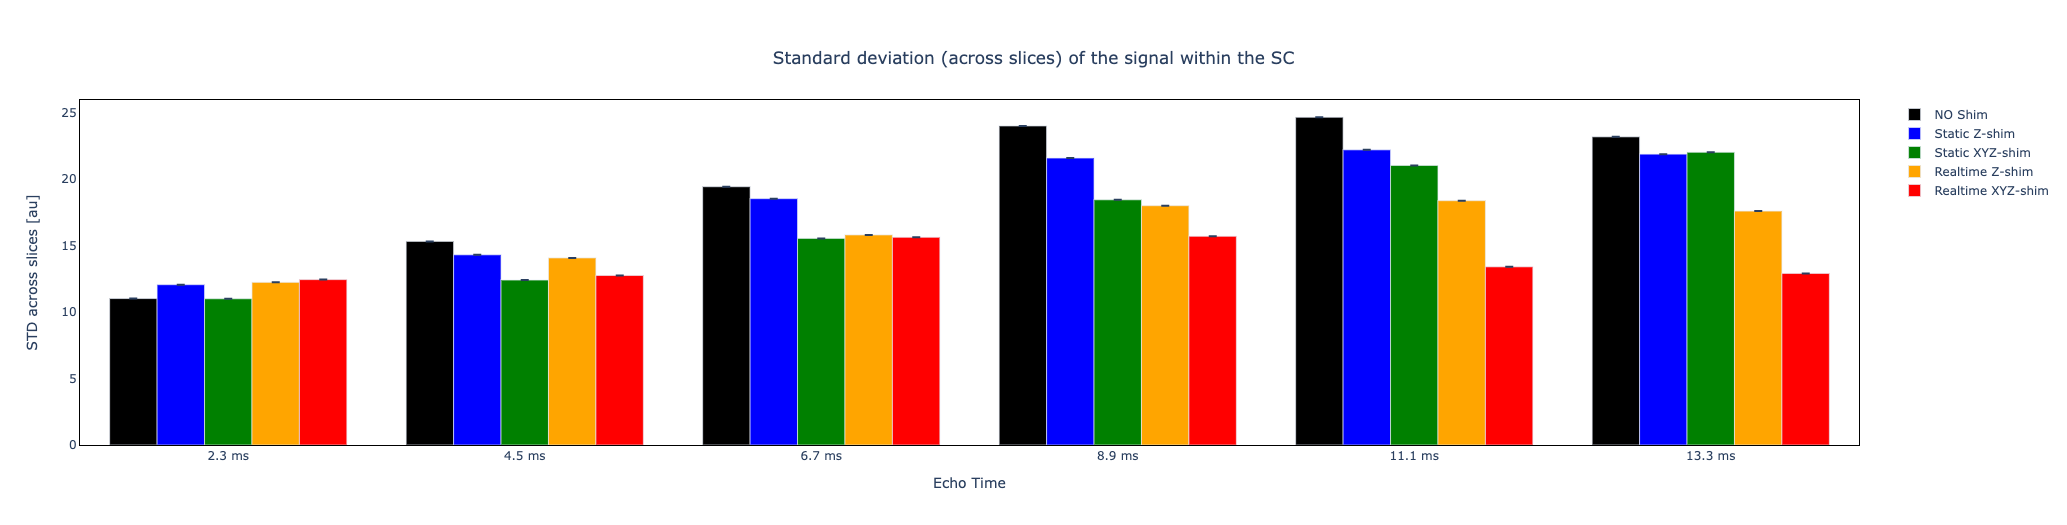

*Figure 3: Standard deviation of the signal within the SC across all slices of the MGRE scans for each echo and shim condition. For echo times in excess of 2.3 ms field inhomogeneities lead to increased signal variability (**noshim**, blue). Static correction gradients (**ST-zshim**, red; **ST-xyzshim**, yellow) reduce this variability, but realtime compensation (**RT-zshim**, purple; **RT-xyzshim**, green) is required for full compensation.*



In Figure 4 we see the average within-spinal-cord signal intensity averaged across slices (mean_slices) for each echo and each shim condition (an interactive version of this figure can be generated in the "Analysis" section). mean_slices decreased from TE1 to TE6 in the **noshim** condition by ~ 36%. In the **ST-zshim**, there was a decrease of ~ 37%. For **ST-xyzshim**, there was a decrease of ~ 36 %, for **RT-zshim** there was a decrease of ~ 26%, and for **RT-xyzshim** the decrease was ~ 28%. 

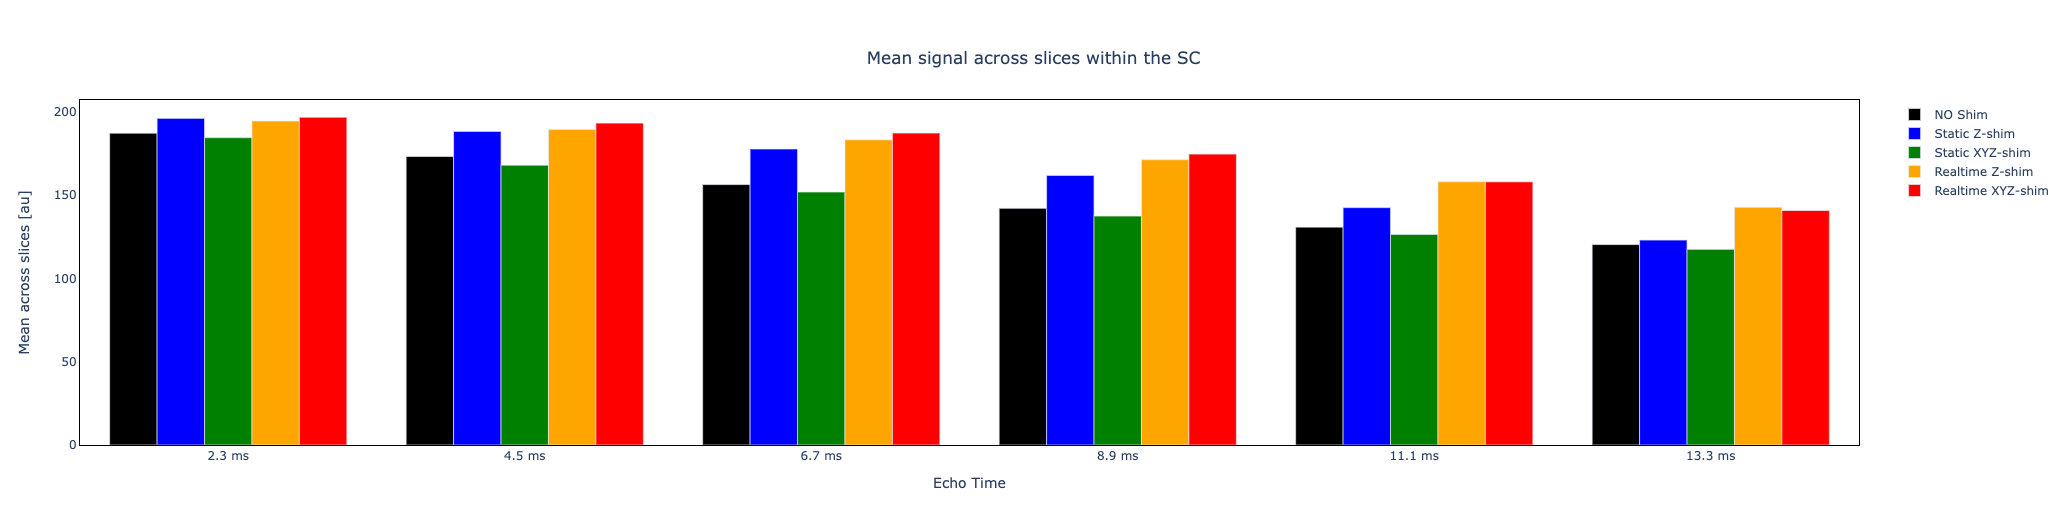

*Figure 4: The mean of the signal within the SC averaged across all slices (mean_slices) of the MGRE scans for each echo and shim condition. **noshim** (blue), **ST-zshim** (red), **ST-xyzshim** (yellow), **RT-zshim** (purple), **RT-xyzshim** (green).*


In Figure 5 we show the distribution of within-slice average signal signals across slices for each echo time and shim condition. Panel A shows the **noshim** (black) distribution compared to the **ST-zshim** (blue), panel B shows the **noshim** (black) distribution compared to the **ST-xyzshim** (green), panel C shows the **noshim** (black) distribution compared to the **RT-zshim** (yellow), and panel D shows the **noshim** (black) distribution compared to the **RT-xyzshim** (red). Here we observe a gradual recovery of the signal and successive narrrowing of the distributions with each shim condition (from panel A to panel D). Additional versions of these figures can be generated in the "Analysis" section.

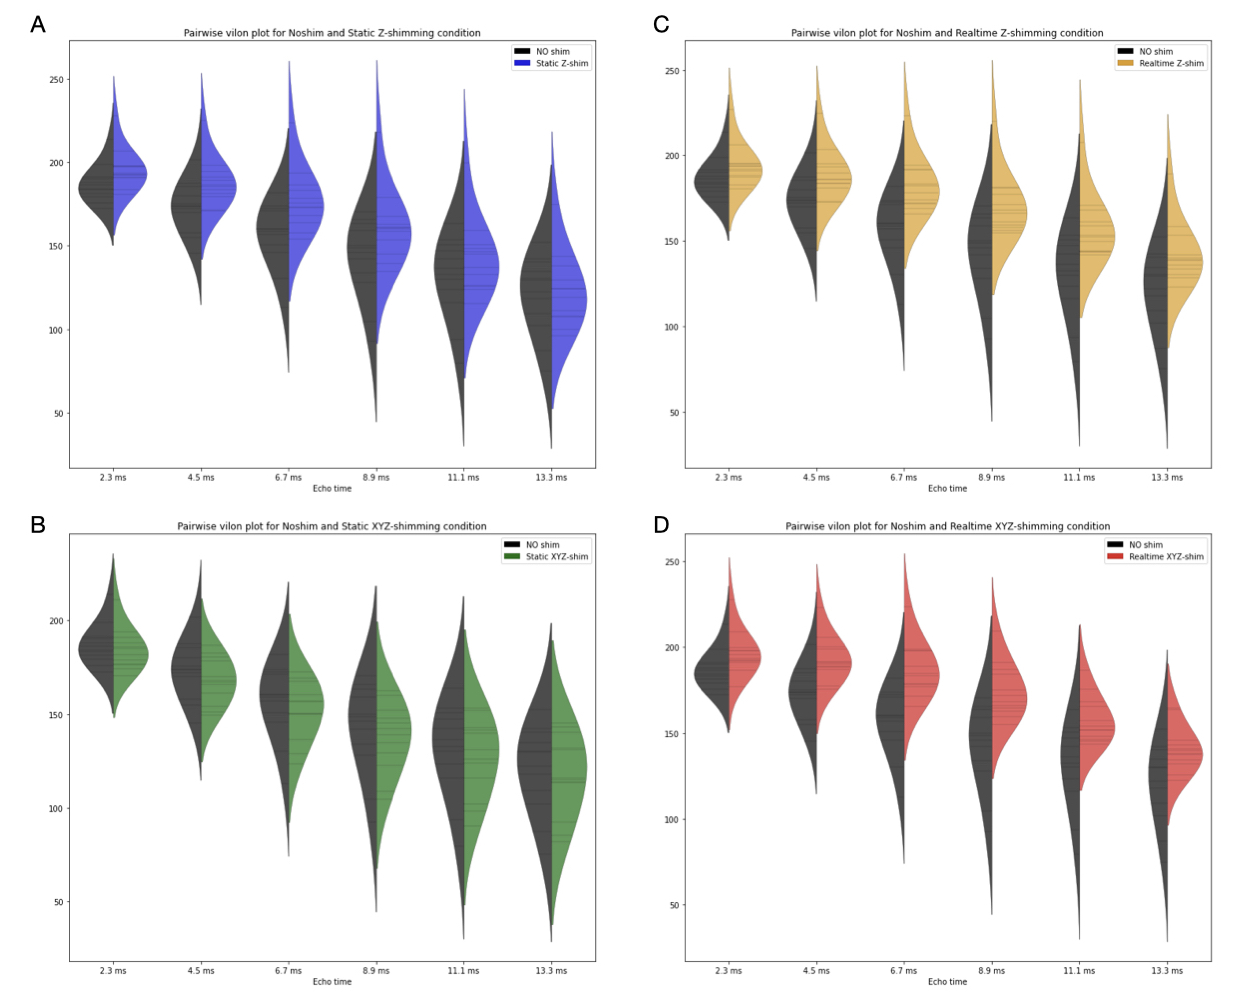


*Figure 5 (A) **noshim** (black) distribution of within-slice average signals across slices for each echo time compared to the **ST-zshim** (blue), (B) **noshim** (black) vs. **ST-xyzshim** (green), (C) **noshim** (black)  vs. **RT-zshim** (yellow), (D) **noshim** (black) vs. **RT-xyzshim** (red).*

# Discussion

In this work, we observed that in the absence of dynamic shimming of any kind, MGRE signals at later echo times are adversely affected by magnetic field inhomogeneities. The use of dynamic z-shimming can improve signal homogeneity in the SC [3]. However, here we show that extending this approach to account for respiration-induced magnetic field gradients (realtime dynamic z-shimming) can improve signal homogeneity by 13% (percent change in STD_slices averaged across echo times between dynamic z-shimming and realtime dynamic z-shimming). Additionally, if in-plane magnetic field gradients are included in the realtime compensation, signal homogeneity can be improved by as much as 25% (percent change in STD_slices averaged across echo times between dynamic z-shimming and realtime dynamic xyz-shimming). Further work will focus on acquiring data on a larger group of volunteers and evaluating the effect of different in-plane image resolutions for shimmed acquisitions. Realtime dynamic xyz-shimming is a promising approach for improving image quality in SC MRI that is particularly sensitive to field inhomogeneities, such as T2* mapping, fMRI, or high-field MRI.

# Acknowledgements

Funded by the Canada Research Chair in Quantitative Magnetic Resonance Imaging [950-230815], the Canadian Institute of Health Research [CIHR FDN-143263], the Canada Foundation for Innovation [32454, 34824], the Fonds de Recherche du Québec - Santé [28826], the Natural Sciences and Engineering Research Council of Canada [RGPIN-2019-07244], the Canada First Research Excellence Fund (IVADO and TransMedTech), the Courtois NeuroMod project and the Quebec BioImaging Network [5886, 35450].


# References

1. 	Vannesjo SJ, Miller KL, Clare S, Tracey I. Spatiotemporal characterization of breathing-induced B0 field fluctuations in the cervical spinal cord at 7T. Neuroimage. 2018;167: 191–202.
2. 	Alonso-Ortiz E, Tous C, Topfer R, Cohen-Adad J. Real-Time Z-Shimming for Magnetic Resonance Imaging of the Spinal Cord. Proceedings of the 28th Annual Meeting of ISMRM, Sydney, Australia. 2020.
3. 	Finsterbusch J, Eippert F, Büchel C. Single, slice-specific z-shim gradient pulses improve T2*-weighted imaging of the spinal cord. Neuroimage. 2012;59: 2307–2315.
4. 	D’Astous A, Topfer R, Cereza G, Alonso-Ortiz E, Craven-Brightman L, Stockmann J, et al. Shimming-Toolbox: An open-source software package for performing realtime B0 shimming experiments. Available: https://github.com/shimming-toolbox/shimming-toolbox/blob/master/examples/realtime_zshimming.sh
5. 	De Leener B, Lévy S, Dupont SM, Fonov VS, Stikov N, Louis Collins D, et al. SCT: Spinal Cord Toolbox, an open-source software for processing spinal cord MRI data. Neuroimage. 2017;145: 24–43.
